# Machine Learning Project: Control Pong Game With Reinforcement Learning

#### by Sahand Raoufiirani
#### CS445 Spring 2018
#### Professor Chuck Anderson
## Overview

In this project, I've implemented a simple one player Pong Game using  Pygame, and I've applied the reinforcement learning algorithm called Q-learning using neural network to that. I've used our previous worked class called neuralnetworksA4 to apply neural networking. I've considered the ball as the goal in my reinforcement algorithm and the bar is trying to get closer to ball to win the game. When the game starts it tries to learn it over iterations, so after few iterations it works better. As bar is learning to get closer to the ball, it has a state, which has three elements: position, velocity, goal. This program requires to have Pygame installed on the machine to run. The area is divided to 8 sub areas so the goal values can be beween 1 to 8

### Methods:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygame.locals import *
import random
import time
import pygame as pg
%matplotlib inline
import neuralnetworksA4 as nn

The class state stores the location of the rectangular bar it consists of the general information about its coordinates and also of the coordinates of the circle. The class Circle stores the coordinates of the circle centre of the circle.

In [2]:
class State:
    def __init__(self, rect, circle):
        self.rect = rect
        self.circle = circle

class Circle:
    def __init__(self, circleX, circleY):
        self.circleX = circleX
        self.circleY = circleY


the calculate_score function calculates the score and return 1 if the bar hits the ball and otherwize -1. Function newXforCircle generates new position for the ball, and newRect moves the bar

In [3]:
def calculate_score(rect, circle):
    if rect.left <= circle.circleX <= rect.right:
        return 1
    else:
        return -1

def newXforCircle(radius):
    newx = 100 - radius
    multiplier = float(random.randint(1, 10))
    newx *= multiplier
    return newx

def newRect(rect, act):
    if act == 1: #right
        if rect.right + 100 > 800:
            return rect
        else:
            return pg.Rect(rect.left + 100, rect.top, rect.width, rect.height)  
    elif act == -1:  # action is left
        if rect.left - 100 < 0:
            return rect
        else:
            return pg.Rect(rect.left - 100, rect.top, rect.width, rect.height) 
    else: 
        return rect


reinforcement, initialState, and nextState functions specify the dynamic Pong Game. There are three possible actions, -1 means left, 0 is not moving, and 1 bar moves to the right. The reinforcment function calculates the distance between bar and goal, which is the ball. So our state, which is called "s" has three values: position, velocity, and goal. The nextState function updates the state. The goal is integer value between 1 to 8

In [4]:
from copy import copy

actions = (-1, 0, 1)   # Possible actions


def reinforcement(s,s1):
    return -abs(s1[0] - s[2])

def initialState():
    goal = np.random.randint(1,8)
    return np.array([8*np.random.random_sample(), 0.0, goal])

def nextState(s,a):
    s = copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    z = s[2]
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0,z]
    elif s[0] > 10:
        s = [10,0,z]
    return s

In [5]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state,a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state,action)).reshape((1, -1)))
    return action, Q

The makesSamples function creates our samples for this problem

In [6]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.ni))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s,a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn, s[2])

In [10]:
def testIt(Qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    a = plt.subplot(3,3,goal)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet,s,actions,0.0) # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$ and goal='+str(goal))
    return a

In [8]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

This part includes main loop to the program, training, and plots. It trains every 10 iterations, and plots a test for different goals every 500 iterations.

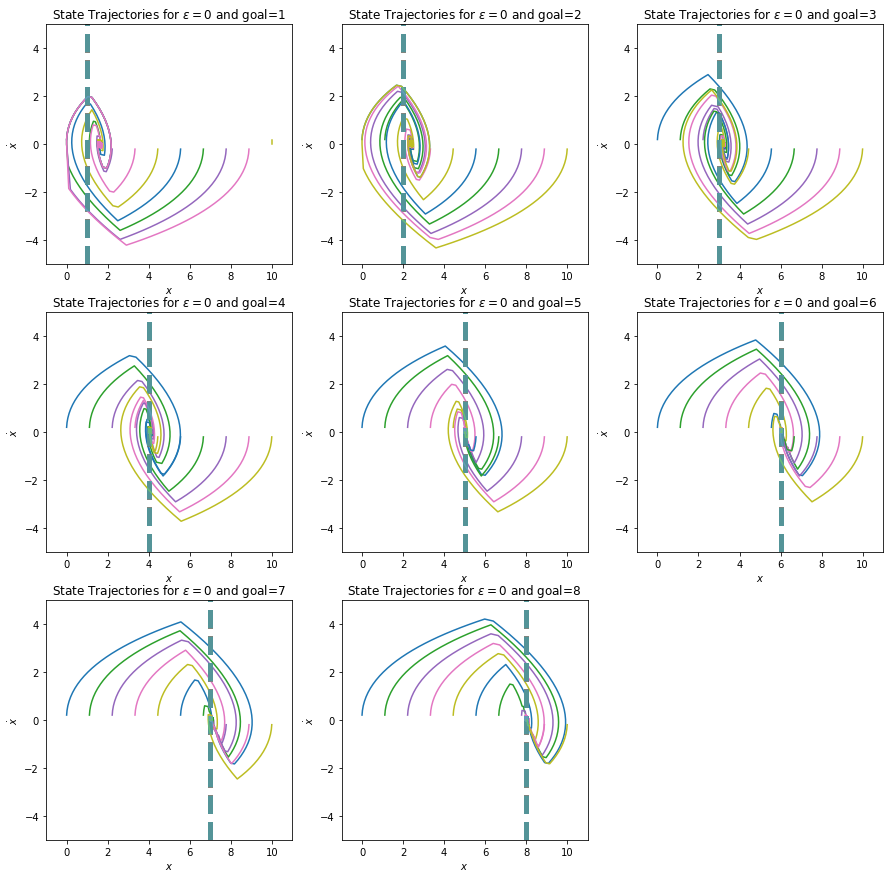

In [11]:
Qa = 0
Left = 400
Top = 570
Width = 100
Height = 20
i = 0
jumpY = 6
jumpX = 8
cenX = 10
cenY = 50
radius = 10
BLACK = (0,0,0)
WHITE = (255,255,255)
GREEN = (0,255,0)
score = 0

start = time.time()

FPS = 30 # frames per second setting
pg.init()  # pygame initialization
fpsClock = pg.time.Clock()
font = pg.font.Font(None, 30)



window = pg.display.set_mode((800, 600))  # width, height
pg.display.set_caption('Reinforcement Learning')
rct = pg.Rect(Left, Top, Width, Height)

from IPython.display import display, clear_output
fig = plt.figure(1,figsize=(10,10))
fig2 = plt.figure(2,figsize=(15,15))
for i in range(1,10):
    plt.subplot(3,3,i)

gamma = 0.8        # discount factor
nTrials = 5000         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)


nh = 10           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)  # ((0,10),(-3,3),(-1,1)))
# Inputs are position (1 to 10) velocity (-3 to 3) "goal", and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])
epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials): 
    reward = 0
    for event in pg.event.get():
        if event.type == QUIT:  
            pg.quit()
            sys.exit()         
    COL = [(255,255,0),(255,215,0),(238,221,130),(218,165,32),(184,134,11),(208,32,144),(238,130,238),(221,160,221),(218,112,214),(186,85,211),(153,50,204),
    (148,0,211),(138,43,226),(173,255,47),(50,205,50),(154,205,50),(34,139,34),(107,142,35),(189,183,107),(240,230,140)]        
    window.fill((0,45,45))
    se = State(rct, Circle(cenX, cenY))
    if cenY >= 590 - Height - radius:
        reward = calculate_score(rct, Circle(cenX, cenY)) 
        if reward == -1:
            cenX = newXforCircle(radius)
            cenY = 50
        else:
            Qa = COL[random.randint(0,19)] 
            jumpY *= -1
            cenY += jumpY
    elif cenY < 50 and i!=0:
        cenY += jumpY
        jumpY = abs(jumpY)

    else:
        cenY+=jumpY

    if cenX >= (800 - radius):
        jumpX *= -1
        cenX += jumpX
    elif cenX <= 2*radius and i!=0:
        cenX += jumpX
        jumpX = abs(jumpX)
    else:
        cenX += jumpX
        #print('b')
    #print (str(cenX))
    #print('X: '+str(jumpX)+'  Y: '+str(jumpY))

    X, R, Qn, goal = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    
    if True and (trial+1 == nTrials or trial % (10) == 0): #training rate
        nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
        qs = nnetQ.use(np.array([[s,0,goal,a] for a in actions for s in range(9)]))
    if True and (trial+1 == nTrials or trial % (500) == 0):
        fig2.clf()  
        plt.figure(2)
        for g in range(1,9):
            act = testIt(nnetQ, 10, 500, g)
        clear_output(wait=True)
        display(fig2)
        print("goal",goal)    
    x= int(((rct.right/100)+(rct.left/100))/2)
    s = [x,0,int(cenX/100)]
    a,_ = epsilonGreedy(nnetQ,s,actions,0.0)
    rct = newRect(se.rect, a)  
    
    if reward == 1: 
        score += reward
    pg.draw.circle(window, Qa, (int(cenX),int(cenY)),radius) 
    pg.draw.rect(window, WHITE, rct)
    end = time.time()
    text = font.render('Score: ' + str(score), True, (243, 160, 90))
    text2 = font.render('Time: ' + str(int(end-start)), True, (0, 255, 20))
    window.blit(text, (670, 10))
    window.blit(text2, (320, 10))
    
    fpsClock.tick(FPS)
    pg.display.update()  # update display
    
clear_output(wait=True)

The plots show different goal positions, and bar starts from different positions and move to the goal, so we can see the velocity changes depending on how far is the marble from the goal, which the doted ara is the goal, so when it gets closer to goal the velocity gets closer to zero.

### Result:

This video shows the program after running 15 seconds, so the bar is moving correct yet:

In [12]:
import io
import base64
from IPython.display import HTML

video = io.open('video1.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="500" height="500" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

This video shows the program after running 115 seconds, so the bar is not accurate yet, but moving correctly:

In [13]:
import io
import base64
from IPython.display import HTML

video = io.open('video2.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="500" height="500" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

This video shows the program after running 2277 seconds, so the bar is moving correctly:

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open('video3.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="500" height="500" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Since the state has velocity it makes it harder to stay in one location and that's why the bar keeps moving. After few runnings it is visible that the training is not helpful anymore and traing for about 600 seconds is enough for this problem.

### Conclusion:

From this project I learned how to use reinforcment learning with neural networks, in other programs such as a Pygame. The difficult part was after building the code of the Pong game, connecting it to the machine learning algorithms. First Iwas implementing with to learn with the achived game score but I realized that would take longer to learn and it's more complex, so I changed it to learn though the distance between ball and the bar.

### Refrences:

Class notes of Machin Learning course at Colorado State University, Spring 2018